# Return Prediction for View and Uncertainty Matrix

In [119]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import yfinance as yf

# Function to preprocess data
def preprocess_data(df):
    df['Date'] = pd.to_datetime(df.index)
    df.set_index('Date', inplace=True)
    df['Future_Return'] = df['Adj Close'].shift(-100) / df['Adj Close'] - 1
    df = df.dropna(subset=['Future_Return'])
    df['SMA_5'] = df['Adj Close'].rolling(window=5).mean()
    df['SMA_200'] = df['Adj Close'].rolling(window=200).mean()
    df = df.dropna()
    features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'SMA_5']
    X = df[features]
    y = df['Future_Return']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y

# Function to train models and perform bootstrapping
def train_and_predict(X_train, y_train, X_test, n_iterations=100):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1, max_depth=5, alpha=10, n_estimators=100)
    }
    predictions = {}

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        preds = np.zeros((n_iterations, X_test.shape[0]))
        for i in range(n_iterations):
            preds[i] = model.predict(X_test)
        predictions[model_name] = preds.mean(axis=0)

    return predictions

# Load data for three companies
tickers = ['NVDA', 'AAPL', 'GOOG']  # Example tickers for Apple, Google, and Microsoft

# Download historical data for each stock
companies_data = []
for ticker in tickers:
    companies_data.append(yf.download(ticker, start="2021-12-31", end="2024-03-31"))

# Preprocess data and split into training and testing sets
data_splits = []
for df in companies_data:
    X, y = preprocess_data(df)
    train_size = int(len(X) - 100)
    data_splits.append((X[:train_size], X[train_size:], y[:train_size], y[train_size:]))

# Initialize matrices to store results
n_companies = len(companies_data)
n_models = 3
returns_matrix = np.zeros((n_companies, n_models))
confidence_intervals_matrix = np.zeros((n_companies, n_models, 2))  # lower and upper bounds
uncertainty_matrix = np.zeros((n_companies, n_models))

# Train models and calculate predictions
predicted_returns = []
for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
    predictions = train_and_predict(X_train, y_train, X_test)
    uncertainties = train_and_predict(X_train, y_train, X_test)
    predicted_returns.append(predictions)

    # Store predictions
    returns_matrix[i, 0] = predictions['Linear Regression'].mean()
    returns_matrix[i, 1] = predictions['Random Forest'].mean()
    returns_matrix[i, 2] = predictions['XGBoost'].mean()

    # Store confidence intervals (95% CI)
    confidence_intervals_matrix[i, 0, 0] = predictions['Linear Regression'].mean() - 1.96 * uncertainties['Linear Regression'].mean()
    confidence_intervals_matrix[i, 0, 1] = predictions['Linear Regression'].mean() + 1.96 * uncertainties['Linear Regression'].mean()
    confidence_intervals_matrix[i, 1, 0] = predictions['Random Forest'].mean() - 1.96 * uncertainties['Random Forest'].mean()
    confidence_intervals_matrix[i, 1, 1] = predictions['Random Forest'].mean() + 1.96 * uncertainties['Random Forest'].mean()
    confidence_intervals_matrix[i, 2, 0] = predictions['XGBoost'].mean() - 1.96 * uncertainties['XGBoost'].mean()
    confidence_intervals_matrix[i, 2, 1] = predictions['XGBoost'].mean() + 1.96 * uncertainties['XGBoost'].mean()

    # Calculate uncertainty as the width of the confidence interval
    uncertainty_matrix[i, 0] = confidence_intervals_matrix[i, 0, 1] - confidence_intervals_matrix[i, 0, 0]
    uncertainty_matrix[i, 1] = confidence_intervals_matrix[i, 1, 1] - confidence_intervals_matrix[i, 1, 0]
    uncertainty_matrix[i, 2] = confidence_intervals_matrix[i, 2, 1] - confidence_intervals_matrix[i, 2, 0]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<ipython-input-119-678ab99c15e1>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_5'] = df['Adj Close'].rolling(window=5).mean()
<ipython-input-119-678ab99c15e1>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_200'] = df['Adj Close'].rolling(window=200).mean()
<ipython-input-119-678ab9

In [120]:
import yfinance as yf
import pandas as pd

# Define the stock tickers
tickers = ['NVDA', 'AAPL', 'GOOG']  # Example tickers for Apple, Google, and Microsoft

# Download historical data for each stock
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start="2021-12-31", end="2024-03-31")[['Open', 'Adj Close']]

# Combine the data into a single DataFrame
df_combined = pd.DataFrame()
for ticker in tickers:
    df_temp = data[ticker].copy()
    df_temp.columns = [f'{ticker}_Open', f'{ticker}_Close']
    df_combined = pd.merge(df_combined, df_temp, left_index=True, right_index=True, how='outer')

# Add a sample risk-free rate (e.g., 1% per year, constant)
df_combined['RiskFreeRate'] = 0.02

# Save the combined DataFrame to a CSV file
df_combined.to_csv('combined_stock_data.csv')

# Display the combined DataFrame
print(df_combined.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

            NVDA_Open  NVDA_Close   AAPL_Open  AAPL_Close   GOOG_Open  \
Date                                                                    
2021-12-31  29.674000   29.366699  178.089996  174.900360  145.544006   
2022-01-03  29.815001   30.075634  177.830002  179.273605  144.475494   
2022-01-04  30.277000   29.245886  182.630005  176.998337  145.550507   
2022-01-05  28.948999   27.562420  179.610001  172.290207  144.181000   
2022-01-06  27.639999   28.135557  172.699997  169.414124  137.497498   

            GOOG_Close  RiskFreeRate  
Date                                  
2021-12-31  144.515060          0.02  
2022-01-03  144.909592          0.02  
2022-01-04  144.252350          0.02  
2022-01-05  137.497040          0.02  
2022-01-06  137.394653          0.02  


In [121]:
assets = ['NVDA_Close', 'AAPL_Close', 'GOOG_Close']
for asset in assets:
    df_combined[f'{asset}_Return'] = df_combined[asset].pct_change()
# Calculate daily return for the risk-free rate
df_combined['RiskFreeRate_Return'] = df_combined['RiskFreeRate'].pct_change()

# Drop NaN values
df_combined.dropna(inplace=True)

# Select return columns
return_columns = [f'{asset}_Return' for asset in assets]
returns = df_combined[return_columns]

print(df_combined.head())

            NVDA_Open  NVDA_Close   AAPL_Open  AAPL_Close   GOOG_Open  \
Date                                                                    
2022-01-03  29.815001   30.075634  177.830002  179.273605  144.475494   
2022-01-04  30.277000   29.245886  182.630005  176.998337  145.550507   
2022-01-05  28.948999   27.562420  179.610001  172.290207  144.181000   
2022-01-06  27.639999   28.135557  172.699997  169.414124  137.497498   
2022-01-07  28.141001   27.205959  172.889999  169.581543  137.904999   

            GOOG_Close  RiskFreeRate  NVDA_Close_Return  AAPL_Close_Return  \
Date                                                                         
2022-01-03  144.909592          0.02           0.024141           0.025004   
2022-01-04  144.252350          0.02          -0.027589          -0.012692   
2022-01-05  137.497040          0.02          -0.057562          -0.026600   
2022-01-06  137.394653          0.02           0.020794          -0.016693   
2022-01-07  136.8487

In [122]:
def calculate_sharpe_ratio_portfolio(returns, weights, risk_free_rate = 0.02, periods_per_year=252):
    """
    Calculate the Sharpe Ratio for a portfolio of assets.

    Parameters:
    returns (pd.DataFrame): DataFrame of daily returns of the assets.
    weights (np.array): Array of portfolio weights.
    risk_free_rate (float): Risk-free rate, expressed as an annualized rate.
    periods_per_year (int): Number of periods per year (252 for daily returns).

    Returns:
    tuple: The portfolio's volatility and Sharpe Ratio.
    """
    # Calculate the mean and covariance of daily returns
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    # Calculate the portfolio return and volatility
    # portfolio_return = np.dot(weights, mean_returns)
    # portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    portfolio_return = (1+np.dot(weights, mean_returns)) ** periods_per_year - 1
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(periods_per_year)

    # # Calculate the annualized risk-free rate per period
    # risk_free_rate_per_period = (1 + risk_free_rate) ** (1 / periods_per_year) - 1

    # Calculate the excess return
    excess_return = portfolio_return - risk_free_rate

    # Calculate the Sharpe Ratio
    sharpe_ratio = excess_return / portfolio_volatility

    return portfolio_return, portfolio_volatility, sharpe_ratio

In [123]:
# Display results
print("Returns Matrix:")
print(returns_matrix)

linear_regression_returns = returns_matrix[:, 0].tolist()
print("Linear Regression Returns:", linear_regression_returns)

random_forest_returns = returns_matrix[:, 1].tolist()
print("Random Forest Returns:", linear_regression_returns)

xg_boost_returns = returns_matrix[:, 2].tolist()
print("XG Boost Returns:", linear_regression_returns)

Returns Matrix:
[[ 0.05904413  0.04623175  0.66398811]
 [-0.05510407 -0.02423204  0.16376455]
 [ 0.05145407  0.02786644  0.2196991 ]]
Linear Regression Returns: [0.059044127911586614, -0.055104071497187504, 0.05145407141636322]
Random Forest Returns: [0.059044127911586614, -0.055104071497187504, 0.05145407141636322]
XG Boost Returns: [0.059044127911586614, -0.055104071497187504, 0.05145407141636322]


In [124]:
# Prepare results for output
results = {'Linear Regression': [], 'Random Forest': [], 'XGBoost': []}
uncertainty_results = {'Linear Regression': [], 'Random Forest': [], 'XGBoost': []}

for model_index, model_name in enumerate(results.keys()):
    for company_index in range(n_companies):
        results[model_name].append(returns_matrix[company_index, model_index])
        uncertainty_results[model_name].append(uncertainty_matrix[company_index, model_index])
for model_name in results:
    results[model_name] = [round(num, 2) for num in results[model_name]]
#this result is the viewDict
print(results)

for model_name in uncertainty_results:
    uncertainty_results[model_name] = [round(num, 1) for num in uncertainty_results[model_name]]
print("uncertainty")
print(uncertainty_results)


# Convert results to DataFrame and display
results_df = pd.DataFrame(results, index=['NVDA', 'AAPL', 'GOOG'])
print(results_df)

uncertainty_df = pd.DataFrame(uncertainty_results, index=['NVDA', 'AAPL', 'GOOG'])
print(uncertainty_df)


{'Linear Regression': [0.06, -0.06, 0.05], 'Random Forest': [0.05, -0.02, 0.03], 'XGBoost': [0.66, 0.16, 0.22]}
uncertainty
{'Linear Regression': [0.2, -0.2, 0.2], 'Random Forest': [0.2, -0.1, 0.1], 'XGBoost': [2.6, 0.6, 0.9]}
      Linear Regression  Random Forest  XGBoost
NVDA               0.06           0.05     0.66
AAPL              -0.06          -0.02     0.16
GOOG               0.05           0.03     0.22
      Linear Regression  Random Forest  XGBoost
NVDA                0.2            0.2      2.6
AAPL               -0.2           -0.1      0.6
GOOG                0.2            0.1      0.9


In [125]:
#ViewDict for Black-LItterman
# for viewDict dictionary
# exmaple
'''viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}
'''
# Using Linear Regression model

linear_regression_returns_viewDict = results_df['Linear Regression'].to_dict()
print(linear_regression_returns_viewDict)

rf_returns_viewDict = results_df['Random Forest'].to_dict()
print(rf_returns_viewDict)

xg_returns_viewDict = results_df['XGBoost'].to_dict()
print(xg_returns_viewDict)

{'NVDA': 0.06, 'AAPL': -0.06, 'GOOG': 0.05}
{'NVDA': 0.05, 'AAPL': -0.02, 'GOOG': 0.03}
{'NVDA': 0.66, 'AAPL': 0.16, 'GOOG': 0.22}


In [126]:
print(results_df['Linear Regression'].tolist())

[0.06, -0.06, 0.05]


In [55]:
'''lr_weights = np.array(results_df['Linear Regression'].tolist())
portfolio_volatility, sharpe_ratio = calculate_sharpe_ratio_portfolio(returns,lr_weights, 0.02)
print(f"Portfolio Volatility: {portfolio_volatility:.4f}")
print(f"Sharpe Ratio for the portfolio: {sharpe_ratio:.4f}")
'''

'lr_weights = np.array(results_df[\'Linear Regression\'].tolist())\nportfolio_volatility, sharpe_ratio = calculate_sharpe_ratio_portfolio(returns,lr_weights, 0.02)\nprint(f"Portfolio Volatility: {portfolio_volatility:.4f}")\nprint(f"Sharpe Ratio for the portfolio: {sharpe_ratio:.4f}")\n'

In [127]:
#uncertainty matrix
'''confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7,
    0.5,
    0.1,
    0.4
]
'''

linear_regression_confidences = uncertainty_df['Linear Regression'].to_list()
print(linear_regression_confidences)

rf_confidences = uncertainty_df['Random Forest'].to_list()
print(rf_confidences)

xg_confidences = uncertainty_df['XGBoost'].to_list()
print(xg_confidences)

[0.2, -0.2, 0.2]
[0.2, -0.1, 0.1]
[2.6, 0.6, 0.9]


# Portfolio Optimization


In [11]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.9 MB/s eta 0:00:00


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pypfopt import EfficientFrontier, risk_models, black_litterman, expected_returns, BlackLittermanModel, HRPOpt, CLA

In [128]:
tickers = ['NVDA', 'AAPL', 'GOOG']
ohlc = yf.download(tickers, start='2022-01-01',end='2024-01-01')
prices = ohlc["Adj Close"]
prices.head()

[*********************100%%**********************]  3 of 3 completed


Ticker,AAPL,GOOG,NVDA
Date,,,
2022-01-03,179.273605,144.909592,30.075630
2022-01-04,176.998322,144.252350,29.245884
2022-01-05,172.290192,137.497040,27.562424
2022-01-06,169.414108,137.394653,28.135557
2022-01-07,169.581528,136.848770,27.205961


In [129]:
market_prices = yf.download("SPY", start='2022-01-01',end='2024-01-01')["Adj Close"]
market_prices.tail()

[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2023-12-22,470.664490
2023-12-26,472.651886
2023-12-27,473.506500
2023-12-28,473.685333
2023-12-29,472.314026


In [130]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

0.32037815911183104

In [131]:
daily_returns = prices.pct_change().dropna()
mu = expected_returns.mean_historical_return(prices)
daily_returns.head()

Ticker,AAPL,GOOG,NVDA
Date,,,
2022-01-04,-0.012692,-0.004536,-0.027589
2022-01-05,-0.026600,-0.046830,-0.057562
2022-01-06,-0.016693,-0.000745,0.020794
2022-01-07,0.000988,-0.003973,-0.033040
2022-01-10,0.000116,0.011456,0.005615


In [132]:
def deviation_risk_parity(w, cov_matrix):
    diff = w * np.dot(cov_matrix, w) - (w * np.dot(cov_matrix, w)).reshape(-1, 1)
    return (diff**2).sum().sum()

In [133]:
ef = EfficientFrontier(mu, S)
weights = ef.nonconvex_objective(deviation_risk_parity, ef.cov_matrix)
ef.portfolio_performance(verbose=True)

Expected annual return: 7.3%
Annual volatility: 32.8%
Sharpe Ratio: 0.16


(0.07329607730191244, 0.32753408786396854, 0.16271917726025317)

**Black-Litterman**

In [134]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    shares_outstanding = stock.info.get('sharesOutstanding')
    marketCap=stock.history(start="2023-12-29", end="2024-03-31")['Close'].values[0] * shares_outstanding
    mcaps[t] = marketCap
mcaps

{'NVDA': 1217999856371.7188,
 'AAPL': 2916179388266.2188,
 'GOOG': 786199356988.0469}

In [135]:
prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

In [143]:
#linear_regression_returns_viewDict
#rf_returns_viewDict
#xg_returns_viewDict
bl = BlackLittermanModel(S, pi=prior, absolute_views=xg_returns_viewDict, view_confidences=xg_confidences)
rets = bl.bl_returns()
ef = EfficientFrontier(rets, S)
ef.max_sharpe()
print(ef.clean_weights())
predicted_features=ef.portfolio_performance(verbose=True)
predicted_features

OrderedDict([('AAPL', 0.13221), ('GOOG', 0.20736), ('NVDA', 0.66043)])
Expected annual return: 31.2%
Annual volatility: 44.9%
Sharpe Ratio: 0.65


(0.3122209625707867, 0.4485883929196987, 0.6514233698041688)

### Validation

In [144]:
# use wights from the model to calculate the actual annual returns
weights = ef.clean_weights()
weights = np.array(list(weights.values()))

In [145]:
# use wights from the model to calculate the actual annual volatility and sharpe ratio
actual_returns, actual_volatility, actual_sharpe_ratio = calculate_sharpe_ratio_portfolio(returns[-100:], weights, 0.02)
print(f"Portfolio Return: {actual_returns:.4f}")
print(f"Portfolio Volatility: {actual_volatility:.4f}")
print(f"Sharpe Ratio for the portfolio: {actual_sharpe_ratio:.2f}")

Portfolio Return: 0.7259
Portfolio Volatility: 0.2131
Sharpe Ratio for the portfolio: 3.31


In [146]:
# compare the actual features with the predictied features
distance = np.array([actual_returns, actual_volatility, actual_sharpe_ratio]) - predicted_features
distance

array([ 0.41366327, -0.2355333 ,  2.66173012])

**Linear Regression:**

Actual:

Portfolio Return: 0.3456
Portfolio Volatility: 0.2109
Sharpe Ratio for the portfolio: 1.54


Predicted:

Expected annual return: 3.4%
Annual volatility: 46.4%
Sharpe Ratio: 0.03

Distance:
[ 0.3113046 , -0.25333506,  1.51283327]

**Random Forest:**

Actual:

Portfolio Return: 0.5819
Portfolio Volatility: 0.2560
Sharpe Ratio for the portfolio: 2.19



Predicted:

Expected annual return: 4.0%
Annual volatility: 56.3%
Sharpe Ratio: 0.03

Distance:

[ 0.3113046 , -0.25333506,  1.51283327]


**XGBoost:**

Actual:

Portfolio Return: 0.7259
Portfolio Volatility: 0.2131
Sharpe Ratio for the portfolio: 3.31

Predicted:

Expected annual return: 31.2%
Annual volatility: 44.9%
Sharpe Ratio: 0.65

Distance:

[ 0.41366327, -0.2355333 ,  2.66173012]



**Hierarchical risk parity**

Expected annual return: 7.2%
Annual volatility: 33.6%
Sharpe Ratio: 0.16
OrderedDict([('BN', 0.7063331911408421), ('ENPH', 0.11260488652787708), ('FSLR', 0.1810619223312808)])


/usr/local/lib/python3.10/dist-packages/pypfopt/hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.70633319]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


<Axes: >

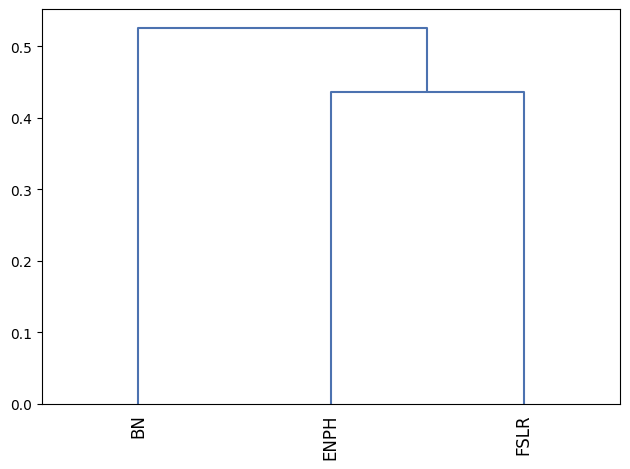

In [25]:
hrp = HRPOpt(daily_returns)
weights = hrp.optimize()
hrp.portfolio_performance(verbose=True)
print(weights)

import pypfopt.plotting as plotting
plotting.plot_dendrogram(hrp)  # to plot dendrogram

In [ ]:
cla = CLA(mu, S)
print(cla.max_sharpe())
cla.portfolio_performance(verbose=True)
plotting.plot_efficient_frontier(cla)  # to plot

# Summary

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

import universal as up
from universal import tools, algos
from universal.algos import *

sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (16, 8)

In [ ]:
# Prepare data for visualizations
'''
model_names = ['Linear Regression', 'Random Forest', 'XGBoost']
company_names = ['Company 1', 'Company 2', 'Company 3']

# Box Plots

for i in range(n_companies):
    plt.figure(figsize=(14, 7))
    data = [predicted_returns[i][model_name] for model_name in model_names]
    plt.boxplot(data, labels=model_names)
    plt.title(f'Box Plot of Predicted Returns for {company_names[i]}')
    plt.ylabel('Expected Return')
    plt.show()

# Line Plots for Actual vs. Predicted Returns
for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
    predictions = predicted_returns[i]

    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Returns', color='blue')
    plt.plot(y_test.index, predictions['Linear Regression'], label='Predicted Returns - Linear Regression', color='red')
    plt.plot(y_test.index, predictions['Random Forest'], label='Predicted Returns - Random Forest', color='green')
    plt.plot(y_test.index, predictions['XGBoost'], label='Predicted Returns - XGBoost', color='orange')
    plt.title(f'Actual vs Predicted Returns for {company_names[i]}')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

# Scatter Plots for Actual vs. Predicted Returns
for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
    predictions = predicted_returns[i]

    plt.figure(figsize=(14, 7))
    plt.scatter(y_test, predictions['Linear Regression'], label='Linear Regression', color='red')
    plt.scatter(y_test, predictions['Random Forest'], label='Random Forest', color='green')
    plt.scatter(y_test, predictions['XGBoost'], label='XGBoost', color='orange')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.title(f'Scatter Plot of Actual vs Predicted Returns for {company_names[i]}')
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.show()
'''

In [ ]:

print("\nConfidence Intervals Matrix (95% CI):")
print(confidence_intervals_matrix)

# Prepare data for visualizations
model_names = ['Linear Regression', 'Random Forest', 'XGBoost']
company_names = ['Company 1', 'Company 2', 'Company 3']

# Plot predicted returns with confidence intervals
for i in range(n_companies):
    plt.figure(figsize=(14, 7))
    for j in range(n_models):
        plt.errorbar(j, returns_matrix[i, j],
                     yerr=[[returns_matrix[i, j] - confidence_intervals_matrix[i, j, 0]], [confidence_intervals_matrix[i, j, 1] - returns_matrix[i, j]]],
                     fmt='o', capsize=5, label=f'{model_names[j]} Mean Return')
    plt.title(f'Returns and Confidence Intervals for {company_names[i]}')
    plt.xlabel('Model')
    plt.ylabel('Expected Return')
    plt.xticks(range(n_models), model_names)
    plt.legend()
    plt.show()

In [ ]:
import seaborn as sns

for i in range(n_companies):
    plt.figure(figsize=(14, 7))
    for model_name in model_names:
        sns.kdeplot(predicted_returns[i][model_name], label=model_name)
    plt.title(f'Density Plot of Predicted Returns for {company_names[i]}')
    plt.xlabel('Expected Return')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [ ]:
model_names = ['Linear Regression', 'Random Forest', 'XGBoost']
company_names = ['Company 1', 'Company 2', 'Company 3']

for i in range(n_companies):
    plt.figure(figsize=(14, 7))
    for j in range(n_models):
        plt.bar(j, returns_matrix[i, j], label=f'{model_names[j]} Mean Return')
    plt.title(f'Predicted Returns for {company_names[i]}')
    plt.xlabel('Model')
    plt.ylabel('Expected Return')
    plt.xticks(range(n_models), model_names)
    plt.legend()
    plt.show()

In [ ]:
for i, (X_train, X_test, y_train, y_test) in enumerate(data_splits):
    predictions = train_and_predict(X_train, y_train, X_test)

    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual Returns', color='blue')
    plt.plot(y_test.index, predictions['LinearRegression'], label='Predicted Returns - Linear Regression', color='red')
    plt.plot(y_test.index, predictions['RandomForest'], label='Predicted Returns - Random Forest', color='green')
    plt.plot(y_test.index, predictions['XGBoost'], label='Predicted Returns - XGBoost', color='orange')
    plt.title(f'Actual vs Predicted Returns for {company_names[i]}')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()